In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

base_path = '/Users/weilynnw/Documents/GitHub/CEE690-ESAA/assignment_2_data'

# Assignment 2: Reservoir Hydrological Analysis

## Execution Order:

**Step 1**: Run all cells in order from top to bottom

**Step 2**: Key execution cells:
- Cell with `main()` → Generates Tasks 1 & 2 outputs
- Cell with `analyze_reservoir_mass_balance()` → Generates Tasks 3, 4, 5 outputs  
- Cell with `plot_flood_vs_low_storage_scatter()` → Generates Task 6 output

**Important**: Make sure to run the mass balance analysis cell BEFORE the scatter plot cell!


 # UTILITY FUNCTIONS


In [9]:

def circular_day_difference(day1, day2, year_length=365):
    """Calculate smallest circular difference between two days of water year."""
    diff = day2 - day1
    
    # Find shortest path around the circle
    if abs(diff) > year_length / 2:
        if diff > 0:
            diff = diff - year_length
        else:
            diff = diff + year_length
    
    return diff

def get_day_of_water_year(date):
    """Convert date to day of water year (1-365)."""
    if date.month >= 10:
        wy_start = pd.Timestamp(date.year, 10, 1)
    else:
        wy_start = pd.Timestamp(date.year - 1, 10, 1)
    
    return (date - wy_start).days + 1

def add_water_year(df):
    """Add water year column (Oct-Sep)"""
    df['water_year'] = df['date'].apply(
        lambda x: x.year if x.month < 10 else x.year + 1
    )
    return df

# Load and preprocess reservoir data


In [10]:
def load_and_preprocess(filepath):
    df = pd.read_csv(filepath)
    
    # Rename columns for consistency
    df = df.rename(columns={
        'datetime': 'date',
        'inflow_cfs': 'inflow',
        'outflow_cfs': 'outflow'
    })
    
    df['date'] = pd.to_datetime(df['date'])
    
    # Remove Feb 29 from leap years (Tip 1)
    df = df[~((df['date'].dt.month == 2) & (df['date'].dt.day == 29))].copy()
    
    df = add_water_year(df)
    
    df = df.sort_values('date').reset_index(drop=True)
    
    return df

 # INDICATOR CALCULATIONS


In [11]:
def calculate_indicator_a(df):
    """(a) Percent change of average annual alteration of 3-day peak flow."""
    results = []
    
    for wy in sorted(df['water_year'].unique()):
        wy_data = df[df['water_year'] == wy]
        
        if len(wy_data) < 3:
            continue
        
        # Calculate 3-day rolling average peak
        in_3day_peak = wy_data['inflow'].rolling(window=3, center=False).mean().max()
        out_3day_peak = wy_data['outflow'].rolling(window=3, center=False).mean().max()

        pct_change = 100 * (out_3day_peak - in_3day_peak) / in_3day_peak
        
        results.append({
            'water_year': wy,
            'in_3day_peak': in_3day_peak,
            'out_3day_peak': out_3day_peak,
            'pct_change': pct_change
        })
    
    return pd.DataFrame(results)

def calculate_indicator_b(df):
    """(b) Percent change of average annual alteration of 31-day low flow."""
    results = []
    
    for wy in sorted(df['water_year'].unique()):
        wy_data = df[df['water_year'] == wy]
        
        if len(wy_data) < 31:
            continue
        
        # Calculate 31-day rolling average minimum
        in_31day_low = wy_data['inflow'].rolling(window=31, center=False).mean().min()
        out_31day_low = wy_data['outflow'].rolling(window=31, center=False).mean().min()
        
        # Calculate percent change
        pct_change = 100 * (out_31day_low - in_31day_low) / in_31day_low
        
        results.append({
            'water_year': wy,
            'in_31day_low': in_31day_low,
            'out_31day_low': out_31day_low,
            'pct_change': pct_change
        })
    
    return pd.DataFrame(results)

def calculate_indicator_c(df):
    """(c) Timing (day of water year) of 3-day peak flow."""
    results = []
    
    for wy in sorted(df['water_year'].unique()):
        wy_data = df[df['water_year'] == wy].copy()
        
        if len(wy_data) < 3:
            continue
        
        # Calculate 3-day rolling average
        wy_data['in_rolling_3day'] = wy_data['inflow'].rolling(window=3, center=False).mean()
        wy_data['out_rolling_3day'] = wy_data['outflow'].rolling(window=3, center=False).mean()
        
        # Find timing of peak
        in_peak_idx = wy_data['in_rolling_3day'].idxmax()
        out_peak_idx = wy_data['out_rolling_3day'].idxmax()
        
        in_peak_date = wy_data.loc[in_peak_idx, 'date']
        out_peak_date = wy_data.loc[out_peak_idx, 'date']
        
        # Convert to day of water year
        in_day = get_day_of_water_year(in_peak_date)
        out_day = get_day_of_water_year(out_peak_date)
        
        # Calculate circular difference
        timing_diff = circular_day_difference(in_day, out_day)
        
        results.append({
            'water_year': wy,
            'in_timing': in_day,
            'out_timing': out_day,
            'timing_diff': timing_diff
        })
    
    return pd.DataFrame(results)

def calculate_indicator_d(df):
    """(d) Timing (day of water year) of 31-day low flow."""
    results = []
    
    for wy in sorted(df['water_year'].unique()):
        wy_data = df[df['water_year'] == wy].copy()
        
        if len(wy_data) < 31:
            continue
        
        # Calculate 31-day rolling average
        wy_data['in_rolling_31day'] = wy_data['inflow'].rolling(window=31, center=False).mean()
        wy_data['out_rolling_31day'] = wy_data['outflow'].rolling(window=31, center=False).mean()
        
        # Find timing of minimum
        in_low_idx = wy_data['in_rolling_31day'].idxmin()
        out_low_idx = wy_data['out_rolling_31day'].idxmin()
        
        in_low_date = wy_data.loc[in_low_idx, 'date']
        out_low_date = wy_data.loc[out_low_idx, 'date']
        
        # Convert to day of water year
        in_day = get_day_of_water_year(in_low_date)
        out_day = get_day_of_water_year(out_low_date)
        
        # Calculate circular difference
        timing_diff = circular_day_difference(in_day, out_day)
        
        results.append({
            'water_year': wy,
            'in_timing': in_day,
            'out_timing': out_day,
            'timing_diff': timing_diff
        })
    
    return pd.DataFrame(results)

def calculate_indicator_e(df):
    """(e) Flashiness (Richards-Baker Index)."""
    results = []
    
    for wy in sorted(df['water_year'].unique()):
        wy_data = df[df['water_year'] == wy]
        
        if len(wy_data) < 2:
            continue
        
        # Calculate RBI for inflow
        in_diff = wy_data['inflow'].diff().abs().sum()
        in_total = wy_data['inflow'].sum()
        in_rbi = in_diff / in_total if in_total > 0 else np.nan
        
        # Calculate RBI for outflow
        out_diff = wy_data['outflow'].diff().abs().sum()
        out_total = wy_data['outflow'].sum()
        out_rbi = out_diff / out_total if out_total > 0 else np.nan
        
        # Difference
        rbi_diff = out_rbi - in_rbi
        
        results.append({
            'water_year': wy,
            'in_rbi': in_rbi,
            'out_rbi': out_rbi,
            'rbi_diff': rbi_diff
        })
    
    return pd.DataFrame(results)


Found 9 reservoir(s):
  - FOL-daily-flows.csv
  - NML-daily-flows.csv
  - DNP-daily-flows.csv
  - PNF-daily-flows.csv
  - CLE-daily-flows.csv
  - SHA-daily-flows.csv
  - EXC-daily-flows.csv
  - ORO-daily-flows.csv
  - BER-daily-flows.csv

Analyzing: FOL
Date range: 2015-10-01 to 2021-09-30
Total days: 2190
Water years: [2016, 2017, 2018, 2019, 2020, 2021]

Results (averaged across 6 water years):
  (a) Avg % change 3-day peak:     -28.72%
  (b) Avg % change 31-day low:      61.79%
  (c) Avg timing diff 3-day:         25.8 days
  (d) Avg timing diff 31-day:        48.2 days
  (e) Avg RBI difference:         -0.1104

Analyzing: NML
Date range: 2015-10-01 to 2021-09-30
Total days: 2190
Water years: [2016, 2017, 2018, 2019, 2020, 2021]

Results (averaged across 6 water years):
  (a) Avg % change 3-day peak:     -10.44%
  (b) Avg % change 31-day low:     -47.79%
  (c) Avg timing diff 3-day:         71.7 days
  (d) Avg timing diff 31-day:        63.5 days
  (e) Avg RBI difference:          

TypeError: cannot unpack non-iterable NoneType object

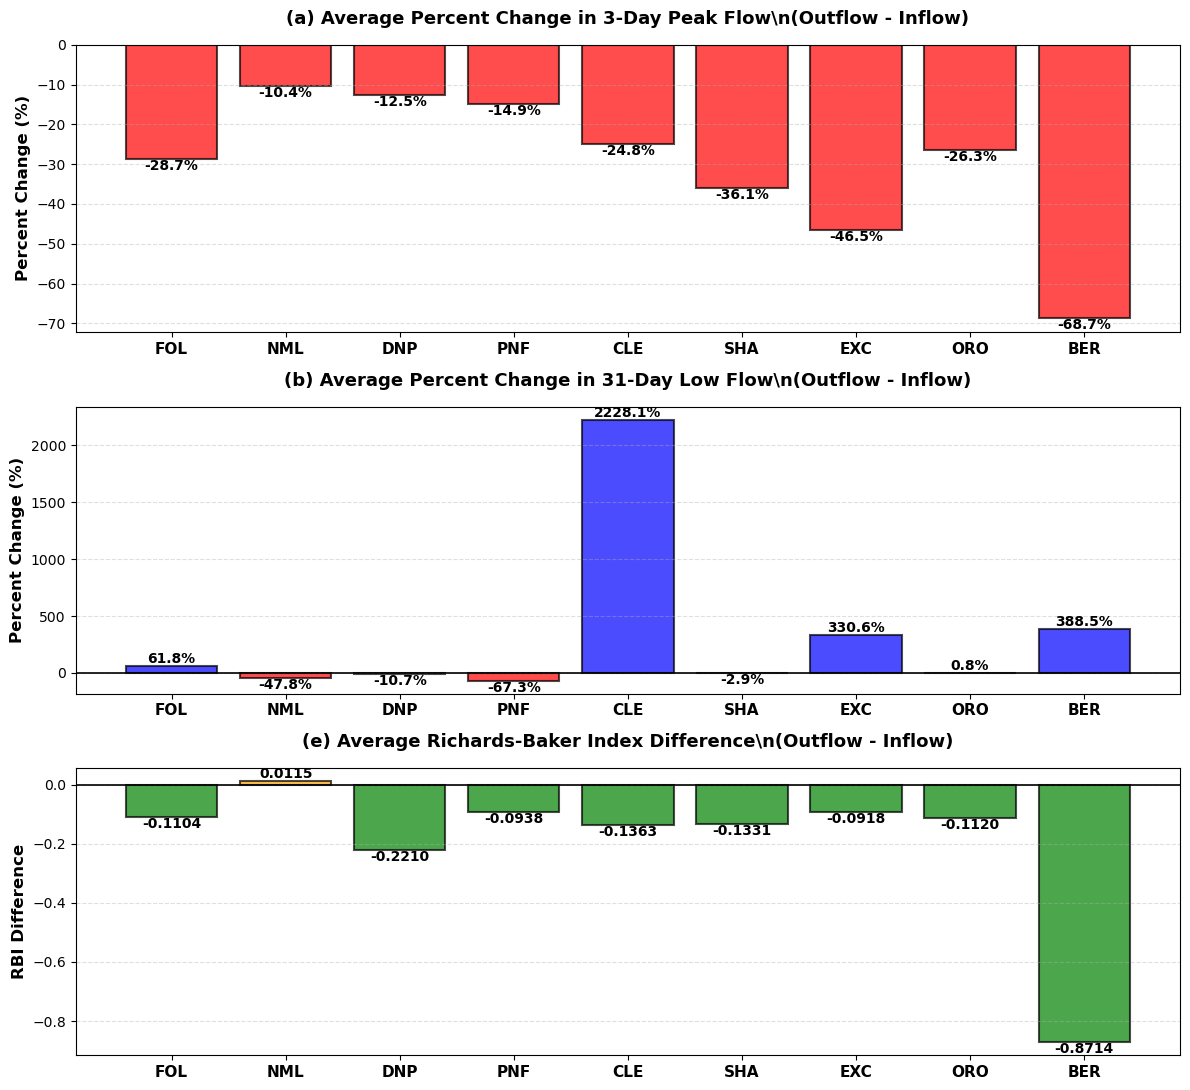

In [12]:
# ANALYSIS FUNCTIONS
def analyze_reservoir(filepath, reservoir_name):
    """Analyze a single reservoir."""
    print(f"\n{'='*60}")
    print(f"Analyzing: {reservoir_name}")
    print(f"{'='*60}")
    
    # Load and preprocess
    df = load_and_preprocess(filepath)
    
    print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
    print(f"Total days: {len(df)}")
    print(f"Water years: {sorted(df['water_year'].unique())}")
    
    # Calculate all indicators
    results = {
        'a_3day_peak_pct': calculate_indicator_a(df),
        'b_31day_low_pct': calculate_indicator_b(df),
        'c_3day_timing': calculate_indicator_c(df),
        'd_31day_timing': calculate_indicator_d(df),
        'e_flashiness': calculate_indicator_e(df)
    }
    
    # Print summary statistics
    print(f"\nResults (averaged across {len(results['a_3day_peak_pct'])} water years):")
    print(f"  (a) Avg % change 3-day peak:   {results['a_3day_peak_pct']['pct_change'].mean():>8.2f}%")
    print(f"  (b) Avg % change 31-day low:   {results['b_31day_low_pct']['pct_change'].mean():>8.2f}%")
    print(f"  (c) Avg timing diff 3-day:     {results['c_3day_timing']['timing_diff'].mean():>8.1f} days")
    print(f"  (d) Avg timing diff 31-day:    {results['d_31day_timing']['timing_diff'].mean():>8.1f} days")
    print(f"  (e) Avg RBI difference:        {results['e_flashiness']['rbi_diff'].mean():>8.4f}")
    
    return results, df

def analyze_multiple_reservoirs(data_dir):
    """Analyze all reservoirs in the data directory."""
    all_results = {}
    
    data_path = Path(data_dir)
    
    # Find all CSV files
    csv_files = list(data_path.glob('*-daily-flows.csv'))
    
    if not csv_files:
        print(f"ERROR: No '*-daily-flows.csv' files found in {data_dir}")
        return None
    
    print(f"\nFound {len(csv_files)} reservoir(s):")
    for f in csv_files:
        print(f"  - {f.name}")
    
    # Analyze each reservoir
    for csv_file in csv_files:
        # Extract reservoir name (e.g., 'BER' from 'BER-daily-flows.csv')
        res_name = csv_file.stem.replace('-daily-flows', '')
        
        results, df = analyze_reservoir(csv_file, res_name)
        all_results[res_name] = results
    
    return all_results

def create_summary_table(all_results):
    """Create summary dataframe with average values for each reservoir."""
    summary = []
    
    for res_name, results in all_results.items():
        summary.append({
            'Reservoir': res_name,
            'Avg_3day_peak_%_change': results['a_3day_peak_pct']['pct_change'].mean(),
            'Avg_31day_low_%_change': results['b_31day_low_pct']['pct_change'].mean(),
            'Avg_3day_timing_shift_days': results['c_3day_timing']['timing_diff'].mean(),
            'Avg_31day_timing_shift_days': results['d_31day_timing']['timing_diff'].mean(),
            'Avg_RBI_difference': results['e_flashiness']['rbi_diff'].mean(),
            'Num_water_years': len(results['a_3day_peak_pct'])
        })
    
    return pd.DataFrame(summary)

# VISUALIZATION

def plot_indicators(summary_df, output_dir='/home/claude/'):
    """Create bar plots for indicators (a), (b), and (e)."""
    reservoirs = summary_df['Reservoir'].tolist()
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 11))
    
    # Plot (a): 3-day peak flow percent change
    ax = axes[0]
    values_a = summary_df['Avg_3day_peak_%_change'].values
    colors_a = ['red' if v < 0 else 'blue' for v in values_a]
    
    bars_a = ax.bar(range(len(reservoirs)), values_a, color=colors_a, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_xticks(range(len(reservoirs)))
    ax.set_xticklabels(reservoirs, fontsize=11, fontweight='bold')
    ax.set_ylabel('Percent Change (%)', fontsize=12, fontweight='bold')
    ax.set_title('(a) Average Percent Change in 3-Day Peak Flow\\n(Outflow - Inflow)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2)
    ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=0.8)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars_a, values_a)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=10, fontweight='bold')
    
    # Plot (b): 31-day low flow percent change
    ax = axes[1]
    values_b = summary_df['Avg_31day_low_%_change'].values
    colors_b = ['blue' if v > 0 else 'red' for v in values_b]
    
    bars_b = ax.bar(range(len(reservoirs)), values_b, color=colors_b, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_xticks(range(len(reservoirs)))
    ax.set_xticklabels(reservoirs, fontsize=11, fontweight='bold')
    ax.set_ylabel('Percent Change (%)', fontsize=12, fontweight='bold')
    ax.set_title('(b) Average Percent Change in 31-Day Low Flow\\n(Outflow - Inflow)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2)
    ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=0.8)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars_b, values_b)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=10, fontweight='bold')
    
    # Plot (e): RBI difference
    ax = axes[2]
    values_e = summary_df['Avg_RBI_difference'].values
    colors_e = ['green' if v < 0 else 'orange' for v in values_e]
    
    bars_e = ax.bar(range(len(reservoirs)), values_e, color=colors_e, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_xticks(range(len(reservoirs)))
    ax.set_xticklabels(reservoirs, fontsize=11, fontweight='bold')
    ax.set_ylabel('RBI Difference', fontsize=12, fontweight='bold')
    ax.set_title('(e) Average Richards-Baker Index Difference\\n(Outflow - Inflow)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2)
    ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=0.8)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars_e, values_e)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    # Save figure
    output_path = Path(output_dir) / 'reservoir_indicators_analysis.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Plot saved: {output_path}")
    
    return fig



def main():

    data_dir = "/Users/weilynnw/Documents/GitHub/CEE690-ESAA/assignment_2_data"
    
    all_results = analyze_multiple_reservoirs(data_dir)
    
    if all_results is None:
        print("\\nERROR: No data found. Please check file locations.")
        return

    summary_df = create_summary_table(all_results)
    
    print("\\n" + "=" * 80)
    print("SUMMARY TABLE")
    print("=" * 80)
    print(summary_df.to_string(index=False))
    

    print("\\n" + "=" * 80)
    print("GENERATING PLOTS")
    print("=" * 80)
    plot_indicators(summary_df, output_dir='/Users/weilynnw/Documents/GitHub/CEE690-ESAA/A2_output')
    


# RUN ANALYSIS

if __name__ == "__main__":
    results, summary = main()


## Q2:


In [ ]:
# UNIT CONVERSION AND RESERVOIR CAPACITIES

CFS_TO_TAFD = 2.29568411e-5 * 86400 / 1000

print(f"Conversion factor CFS to TAFD: {CFS_TO_TAFD:.10f}")
print(f"Example: 1000 cfs for 1 day = {1000 * CFS_TO_TAFD:.6f} thousand acre-feet")

RESERVOIR_CAPACITIES = {
    'SHA': 4552.0,
    'ORO': 3537.6,
    'FOL': 977.0,
    'NML': 2400.0,
    'DNP': 2030.0,
    'PNF': 1000.0,
    'CLE': 525.0,
    'EXC': 1024.6,
    'BER': 1602.0,
}

print(f"\nReservoir capacities (TAF):")
for res, cap in sorted(RESERVOIR_CAPACITIES.items(), key=lambda x: x[1], reverse=True):
    print(f"  {res}: {cap:,.1f}")

Conversion factor CFS to TAFD: 0.0019834711
Example: 1000 cfs for 1 day = 1.983471 thousand acre-feet

Reservoir capacities (TAF):
  SHA: 4,552.0
  ORO: 3,537.6
  NML: 2,400.0
  DNP: 2,030.0
  BER: 1,602.0
  EXC: 1,024.6
  PNF: 1,000.0
  FOL: 977.0
  CLE: 525.0


In [ ]:
def calculate_reservoir_mass_balance(
    df,
    max_storage_tafd,
    initial_storage_fraction=0.70,
    cfs_to_tafd_factor=CFS_TO_TAFD,
    apply_constraints=True,
    report_violations=True
):

    
    # Create a copy to avoid modifying original
    result_df = df.copy()
    
    # Convert flows from cfs to thousand acre-feet per day
    result_df['inflow_tafd'] = result_df['inflow'] * cfs_to_tafd_factor
    result_df['outflow_tafd'] = result_df['outflow'] * cfs_to_tafd_factor
    
    # Calculate net change (positive = storage increases, negative = storage decreases)
    result_df['net_change_tafd'] = result_df['inflow_tafd'] - result_df['outflow_tafd']
    
    # Initialize storage arrays
    n_days = len(result_df)
    storage_unconstrained = np.zeros(n_days)
    storage_constrained = np.zeros(n_days)
    constraint_violations = np.zeros(n_days, dtype=bool)
    
    # Set initial storage (70% of maximum capacity)
    initial_storage = initial_storage_fraction * max_storage_tafd
    storage_unconstrained[0] = initial_storage
    storage_constrained[0] = initial_storage
    
    # Perform mass balance calculation for each day
    for i in range(1, n_days):
        # Calculate UNCONSTRAINED storage (this is key for flood indicator!)
        storage_unconstrained[i] = storage_unconstrained[i-1] + result_df.loc[i, 'net_change_tafd']
        
        if apply_constraints:
            # Apply physical constraints for the constrained storage
            if storage_unconstrained[i] < 0:
                # Cannot have negative storage
                storage_constrained[i] = 0.0
                constraint_violations[i] = True
            elif storage_unconstrained[i] > max_storage_tafd:
                # Cannot exceed maximum capacity (spillway overflow)
                storage_constrained[i] = max_storage_tafd
                constraint_violations[i] = True
            else:
                # Within physical limits
                storage_constrained[i] = storage_unconstrained[i]
        else:
            # No constraints
            storage_constrained[i] = storage_unconstrained[i]
    
    # Add results to dataframe
    result_df['storage_unconstrained'] = storage_unconstrained
    result_df['storage_tafd'] = storage_constrained
    result_df['storage_percent'] = (storage_constrained / max_storage_tafd) * 100
    result_df['constraint_violation'] = constraint_violations
    
    # CALCULATE FLOOD INDICATOR (before applying constraints!)
    
    # Identify spill days: days where UNCONSTRAINED storage exceeds maximum
    spill_days = storage_unconstrained > max_storage_tafd
    result_df['spill_event'] = spill_days
    
    # Count spill EVENTS (consecutive spill days = 1 event)
    spill_events = []
    in_event = False
    event_start = None
    
    for i in range(n_days):
        if spill_days[i] and not in_event:
            # Start of new spill event
            in_event = True
            event_start = i
        elif not spill_days[i] and in_event:
            # End of spill event
            in_event = False
            event_end = i - 1
            spill_events.append({
                'start_idx': event_start,
                'end_idx': event_end,
                'duration': event_end - event_start + 1,
                'water_year': result_df.loc[event_start, 'water_year']
            })
    
    # Handle case where spill event extends to end of data
    if in_event:
        spill_events.append({
            'start_idx': event_start,
            'end_idx': n_days - 1,
            'duration': n_days - event_start,
            'water_year': result_df.loc[event_start, 'water_year']
        })
    
    # Calculate average annual spill events
    n_years = len(result_df['water_year'].unique())
    total_spill_events = len(spill_events)
    avg_annual_spill_events = total_spill_events / n_years if n_years > 0 else 0
    
    # CALCULATE LOW STORAGE EXPOSURE
    
    # Identify low storage days: days where storage falls below 30% of capacity
    low_storage_threshold = 0.30 * max_storage_tafd
    low_storage_days = storage_constrained < low_storage_threshold
    result_df['low_storage_event'] = low_storage_days
    
    # Count low storage EVENTS (consecutive low storage days = 1 event)
    low_storage_events = []
    in_event = False
    event_start = None
    
    for i in range(n_days):
        if low_storage_days[i] and not in_event:
            # Start of new low storage event
            in_event = True
            event_start = i
        elif not low_storage_days[i] and in_event:
            # End of low storage event
            in_event = False
            event_end = i - 1
            low_storage_events.append({
                'start_idx': event_start,
                'end_idx': event_end,
                'duration': event_end - event_start + 1,
                'water_year': result_df.loc[event_start, 'water_year']
            })
    
    # Handle case where low storage event extends to end of data
    if in_event:
        low_storage_events.append({
            'start_idx': event_start,
            'end_idx': n_days - 1,
            'duration': n_days - event_start,
            'water_year': result_df.loc[event_start, 'water_year']
        })
    
    # Calculate average annual low storage events
    total_low_storage_events = len(low_storage_events)
    avg_annual_low_storage_events = total_low_storage_events / n_years if n_years > 0 else 0
    
    # COMPILE INDICATORS
    
    indicators = {
        'flood_indicator': avg_annual_spill_events,
        'low_storage_exposure': avg_annual_low_storage_events,
        'total_spill_events': total_spill_events,
        'total_low_storage_events': total_low_storage_events,
        'n_years': n_years,
        'spill_events_list': spill_events,
        'low_storage_events_list': low_storage_events
    }
    
    # REPORT RESULTS
    
    if report_violations and apply_constraints:
        n_violations = constraint_violations.sum()
        if n_violations > 0:
            pct_violations = (n_violations / n_days) * 100
            print(f"  ⚠ Constraint violations: {n_violations:,} days ({pct_violations:.2f}%)")
            
            # Count types of violations
            below_zero = (storage_constrained == 0).sum()
            at_max = (storage_constrained == max_storage_tafd).sum()
            if below_zero > 0:
                print(f"    - Empty reservoir: {below_zero:,} days")
            if at_max > 0:
                print(f"    - At maximum capacity: {at_max:,} days")
        else:
            print(f"  ✓ No constraint violations - all values within physical limits")
        
        # Report flood indicator
        print(f"\n  Flood Indicator:")
        print(f"    - Total spill events: {total_spill_events}")
        print(f"    - Average annual spill events: {avg_annual_spill_events:.2f}")
        if total_spill_events > 0:
            avg_duration = np.mean([e['duration'] for e in spill_events])
            print(f"    - Average spill duration: {avg_duration:.1f} days")
        
        # Report low storage exposure
        print(f"\n  Low Storage Exposure (<30% capacity):")
        print(f"    - Total low storage events: {total_low_storage_events}")
        print(f"    - Average annual low storage events: {avg_annual_low_storage_events:.2f}")
        if total_low_storage_events > 0:
            avg_duration = np.mean([e['duration'] for e in low_storage_events])
            print(f"    - Average low storage duration: {avg_duration:.1f} days")
    
    return result_df, indicators


In [ ]:
def plot_storage_timeseries(
    df,
    reservoir_name,
    max_storage_tafd,
    save_path=None,
    show_violations=True
):
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    fig.suptitle(f'{reservoir_name} Reservoir - Mass Balance Simulation', 
                 fontsize=16, fontweight='bold')
    
    # Colors
    color_inflow = '#2E86AB'
    color_outflow = '#A23B72'
    color_storage = '#F18F01'
    color_violation = '#C73E1D'
    
    # Subplot 1: Inflow and Outflow
    ax1 = axes[0]
    ax1.plot(df['date'], df['inflow'], label='Inflow', color=color_inflow, linewidth=1)
    ax1.plot(df['date'], df['outflow'], label='Outflow', color=color_outflow, linewidth=1)
    ax1.set_ylabel('Flow (cfs)', fontweight='bold')
    ax1.set_title('(a) Inflow and Outflow Timeseries', fontweight='bold', loc='left')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Subplot 2: Storage Volume
    ax2 = axes[1]
    ax2.plot(df['date'], df['storage_tafd'], color=color_storage, linewidth=1.5)
    ax2.axhline(y=max_storage_tafd, color='red', linestyle='--', linewidth=2, 
                label=f'Max Capacity ({max_storage_tafd:.0f} TAF)', alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    if show_violations and 'constraint_violation' in df.columns:
        violation_dates = df[df['constraint_violation']]['date']
        violation_storage = df[df['constraint_violation']]['storage_tafd']
        if len(violation_dates) > 0:
            ax2.scatter(violation_dates, violation_storage, color=color_violation, 
                       s=20, zorder=5, label='Constraint Violations', alpha=0.6)
    
    ax2.set_ylabel('Storage (TAF)', fontweight='bold')
    ax2.set_title('(b) Storage Volume Timeseries', fontweight='bold', loc='left')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # Subplot 3: Storage Percentage
    ax3 = axes[2]
    ax3.fill_between(df['date'], 0, df['storage_percent'], 
                     color=color_storage, alpha=0.3)
    ax3.plot(df['date'], df['storage_percent'], color=color_storage, linewidth=1.5)
    ax3.axhline(y=100, color='red', linestyle='--', linewidth=2, 
                label='100% Capacity', alpha=0.7)
    ax3.axhline(y=50, color='orange', linestyle='--', linewidth=1, 
                label='50% Capacity', alpha=0.5)
    ax3.set_ylabel('Storage (%)', fontweight='bold')
    ax3.set_title('(c) Storage as Percentage of Maximum Capacity', fontweight='bold', loc='left')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 110)
    
    # Subplot 4: Daily Storage Change
    ax4 = axes[3]
    colors = ['green' if x >= 0 else 'red' for x in df['net_change_tafd']]
    ax4.bar(df['date'], df['net_change_tafd'], color=colors, alpha=0.6, width=1)
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax4.set_ylabel('Daily Change (TAF)', fontweight='bold')
    ax4.set_xlabel('Date', fontweight='bold')
    ax4.set_title('(d) Daily Storage Change (Inflow - Outflow)', fontweight='bold', loc='left')
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Figure saved: {save_path}")
    
    return fig

In [ ]:
def calculate_storage_statistics(df, reservoir_name, max_storage):
    """Calculate summary statistics for reservoir storage."""
    
    stats = {
        'Reservoir': reservoir_name,
        'Max_Capacity_TAF': max_storage,
        'Initial_Storage_TAF': df['storage_tafd'].iloc[0],
        'Final_Storage_TAF': df['storage_tafd'].iloc[-1],
        'Mean_Storage_TAF': df['storage_tafd'].mean(),
        'Min_Storage_TAF': df['storage_tafd'].min(),
        'Max_Storage_TAF': df['storage_tafd'].max(),
        'Storage_Range_TAF': df['storage_tafd'].max() - df['storage_tafd'].min(),
        'Mean_Storage_Percent': df['storage_percent'].mean(),
        'Min_Storage_Percent': df['storage_percent'].min(),
        'Max_Storage_Percent': df['storage_percent'].max(),
        'Days_Empty': (df['storage_tafd'] == 0).sum(),
        'Days_Full': (df['storage_tafd'] == max_storage).sum(),
        'Constraint_Violations': df['constraint_violation'].sum() if 'constraint_violation' in df.columns else 0,
        'Mean_Daily_Change_TAF': df['net_change_tafd'].mean(),
        'Total_Inflow_TAF': df['inflow_tafd'].sum(),
        'Total_Outflow_TAF': df['outflow_tafd'].sum(),
    }
    
    return stats

In [ ]:
def analyze_reservoir_mass_balance(data_directory, output_directory=None, initial_fraction=0.70):
    """Analyze reservoir mass balance for all reservoirs."""
    
    print("\n" + "="*80)
    print("RESERVOIR MASS BALANCE SIMULATION")
    print("="*80)
    print(f"\nData directory: {data_directory}")
    if output_directory:
        print(f"Output directory: {output_directory}")
    print(f"Initial storage: {initial_fraction*100:.0f}% of maximum capacity")
    print(f"Conversion factor: {CFS_TO_TAFD:.10f} CFS to TAFD")
    
    # Find all CSV files
    data_path = Path(data_directory)
    csv_files = list(data_path.glob('*-daily-flows.csv'))
    
    print(f"\nFound {len(csv_files)} reservoir data file(s)")
    
    results_dict = {}
    all_stats = []
    all_indicators = []
    
    # Process each reservoir
    for csv_file in sorted(csv_files):
        # Extract reservoir code from filename
        reservoir_code = csv_file.stem.split('-')[0].upper()
        
        if reservoir_code not in RESERVOIR_CAPACITIES:
            print(f"\n⚠ Skipping {reservoir_code}: No capacity data available")
            continue
        
        print(f"\n" + "="*80)
        print(f"Processing: {reservoir_code}")
        print("="*80)
        
        # Load data
        df = load_and_preprocess(str(csv_file))
        print(f"  Data range: {df['date'].min().date()} to {df['date'].max().date()}")
        print(f"  Total days: {len(df):,}")
        print(f"  Maximum capacity: {RESERVOIR_CAPACITIES[reservoir_code]:,.0f} TAF")
        
        # Calculate mass balance (now returns tuple!)
        max_storage = RESERVOIR_CAPACITIES[reservoir_code]
        result_df, indicators = calculate_reservoir_mass_balance(
            df,
            max_storage_tafd=max_storage,
            initial_storage_fraction=initial_fraction,
            apply_constraints=True,
            report_violations=True
        )
        
        # Store results
        results_dict[reservoir_code] = result_df
        
        # Add reservoir name to indicators
        indicators['Reservoir'] = reservoir_code
        indicators['Max_Capacity_TAF'] = max_storage
        all_indicators.append(indicators)
        
        # Calculate statistics
        stats = calculate_storage_statistics(result_df, reservoir_code, max_storage)
        all_stats.append(stats)
        
        # Print key statistics
        print(f"\n  Storage Statistics:")
        print(f"    Initial: {stats['Initial_Storage_TAF']:,.1f} TAF ({stats['Initial_Storage_TAF']/max_storage*100:.1f}%)")
        print(f"    Final: {stats['Final_Storage_TAF']:,.1f} TAF ({stats['Final_Storage_TAF']/max_storage*100:.1f}%)")
        print(f"    Mean: {stats['Mean_Storage_TAF']:,.1f} TAF ({stats['Mean_Storage_Percent']:.1f}%)")
        print(f"    Range: {stats['Min_Storage_TAF']:,.1f} - {stats['Max_Storage_TAF']:,.1f} TAF")
        
        # Create plot if output directory specified
        if output_directory:
            output_path = Path(output_directory)
            output_path.mkdir(parents=True, exist_ok=True)
            plot_path = output_path / f'{reservoir_code}_mass_balance.png'
            plot_storage_timeseries(
                result_df,
                reservoir_name=reservoir_code,
                max_storage_tafd=max_storage,
                save_path=str(plot_path),
                show_violations=True
            )
            plt.close()
    
    # Create summary DataFrames
    summary_df = pd.DataFrame(all_stats)
    indicators_df = pd.DataFrame(all_indicators)
    
    # Reorder indicators_df columns
    cols = ['Reservoir', 'Max_Capacity_TAF', 'flood_indicator', 'low_storage_exposure', 
            'total_spill_events', 'total_low_storage_events', 'n_years']
    indicators_df = indicators_df[cols]
    
    # Save summary and indicators if output directory specified
    if output_directory and len(summary_df) > 0:
        output_path = Path(output_directory)
        summary_path = output_path / 'reservoir_storage_summary.csv'
        summary_df.to_csv(summary_path, index=False)
        print(f"\n✓ Summary saved: {summary_path}")
        
        indicators_path = output_path / 'reservoir_indicators.csv'
        indicators_df.to_csv(indicators_path, index=False)
        print(f"✓ Indicators saved: {indicators_path}")
    
    # Display summaries
    print("\n" + "="*80)
    print("STORAGE SUMMARY STATISTICS")
    print("="*80)
    if len(summary_df) > 0:
        display_cols = ['Reservoir', 'Max_Capacity_TAF', 'Mean_Storage_Percent', 
                       'Days_Empty', 'Days_Full', 'Constraint_Violations']
        print(summary_df[display_cols].to_string(index=False))
    
    print("\n" + "="*80)
    print("FLOOD AND LOW STORAGE INDICATORS")
    print("="*80)
    print(indicators_df.to_string(index=False))
    
    print("\n" + "="*80)
    print("✓ MASS BALANCE ANALYSIS COMPLETE!")
    print("="*80)
    
    return results_dict, summary_df, indicators_df


## Run Mass Balance Simulation


In [ ]:
# Run mass balance analysis (Tasks 3, 4, 5)
mass_balance_results, storage_summary, reservoir_indicators = analyze_reservoir_mass_balance(
    data_directory=base_path,
    output_directory='/Users/weilynnw/Documents/GitHub/CEE690-ESAA/A2_output/mass_balance',
    initial_fraction=0.70
)



RESERVOIR MASS BALANCE SIMULATION

Data directory: /Users/weilynnw/Documents/GitHub/CEE690-ESAA/assignment_2_data
Output directory: /Users/weilynnw/Documents/GitHub/CEE690-ESAA/A2_output/mass_balance
Initial storage: 70% of maximum capacity
Conversion factor: 0.0019834711 CFS to TAFD

Found 9 reservoir data file(s)

Processing: BER
  Data range: 2015-10-01 to 2021-09-30
  Total days: 2,190
  Maximum capacity: 1,602 TAF
  ⚠ Constraint violations: 1,715 days (78.31%)
    - At maximum capacity: 1,715 days

  Flood Indicator:
    - Total spill events: 1
    - Average annual spill events: 0.17
    - Average spill duration: 1715.0 days

  Low Storage Exposure (<30% capacity):
    - Total low storage events: 0
    - Average annual low storage events: 0.00

  Storage Statistics:
    Initial: 1,121.4 TAF (70.0%)
    Final: 1,602.0 TAF (100.0%)
    Mean: 1,524.9 TAF (95.2%)
    Range: 1,112.9 - 1,602.0 TAF
  ✓ Figure saved: /Users/weilynnw/Documents/GitHub/CEE690-ESAA/A2_output/mass_balance/BER

## Flood Indicator vs Low Storage Exposure Analysis
This section analyzes the relationship between:


In [ ]:
def plot_flood_vs_low_storage_scatter(indicators_df, save_path=None):
    """Create scatter plot of flood indicator vs low storage exposure."""
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define distinct colors for each reservoir
    colors = {
        'SHA': '#E63946',  # Red
        'ORO': '#F77F00',  # Orange
        'FOL': '#FCBF49',  # Yellow
        'NML': '#06A77D',  # Teal
        'DNP': '#4EA8DE',  # Blue
        'PNF': '#5E60CE',  # Purple
        'CLE': '#9D4EDD',  # Violet
        'EXC': '#F72585',  # Pink
        'BER': '#2B9348',  # Green
    }
    
    # Define marker sizes based on capacity (larger reservoirs = bigger markers)
    max_capacity = indicators_df['Max_Capacity_TAF'].max()
    sizes = (indicators_df['Max_Capacity_TAF'] / max_capacity) * 500 + 100
    
    # Plot each reservoir
    for idx, row in indicators_df.iterrows():
        reservoir = row['Reservoir']
        color = colors.get(reservoir, '#333333')
        
        ax.scatter(
            row['flood_indicator'],
            row['low_storage_exposure'],
            s=sizes.iloc[idx],
            color=color,
            alpha=0.6,
            edgecolors='black',
            linewidth=2,
            label=f"{reservoir} ({row['Max_Capacity_TAF']:.0f} TAF)",
            zorder=3
        )
        
        # Add reservoir labels
        ax.annotate(
            reservoir,
            xy=(row['flood_indicator'], row['low_storage_exposure']),
            xytext=(8, 8),
            textcoords='offset points',
            fontsize=10,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.3, edgecolor='none')
        )
    
    # Formatting
    ax.set_xlabel('Flood Indicator (Average Annual Spill Events)', 
                  fontsize=13, fontweight='bold')
    ax.set_ylabel('Low Storage Exposure (Average Annual Events Below 30%)', 
                  fontsize=13, fontweight='bold')
    ax.set_title('Reservoir Flood vs Low Storage Trade-off Analysis', 
                 fontsize=15, fontweight='bold', pad=20)
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Add quadrant lines at median values
    median_flood = indicators_df['flood_indicator'].median()
    median_low = indicators_df['low_storage_exposure'].median()
    
    ax.axvline(median_flood, color='gray', linestyle='--', alpha=0.5, linewidth=1.5, 
              label=f'Median Flood ({median_flood:.2f})')
    ax.axhline(median_low, color='gray', linestyle='--', alpha=0.5, linewidth=1.5,
              label=f'Median Low Storage ({median_low:.2f})')
    
    # Add quadrant labels
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Top-right quadrant
    ax.text(xlim[1]*0.95, ylim[1]*0.95, 'High Flood\n& High Low Storage',
           ha='right', va='top', fontsize=9, style='italic',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Top-left quadrant  
    ax.text(xlim[0]*1.05, ylim[1]*0.95, 'Low Flood\n& High Low Storage',
           ha='left', va='top', fontsize=9, style='italic',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Bottom-right quadrant
    ax.text(xlim[1]*0.95, ylim[0]*1.05, 'High Flood\n& Low Low Storage',
           ha='right', va='bottom', fontsize=9, style='italic',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Bottom-left quadrant
    ax.text(xlim[0]*1.05, ylim[0]*1.05, 'Low Flood\n& Low Low Storage\n(Well Balanced)',
           ha='left', va='bottom', fontsize=9, style='italic',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Legend with reservoir names and capacities
    legend = ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
                      fontsize=9, title='Reservoir (Capacity)',
                      title_fontsize=10, framealpha=0.9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Scatter plot saved: {save_path}")
    
    return fig, ax


✓ Scatter plot saved: /Users/weilynnw/Documents/GitHub/CEE690-ESAA/A2_output/flood_vs_low_storage_scatter.png


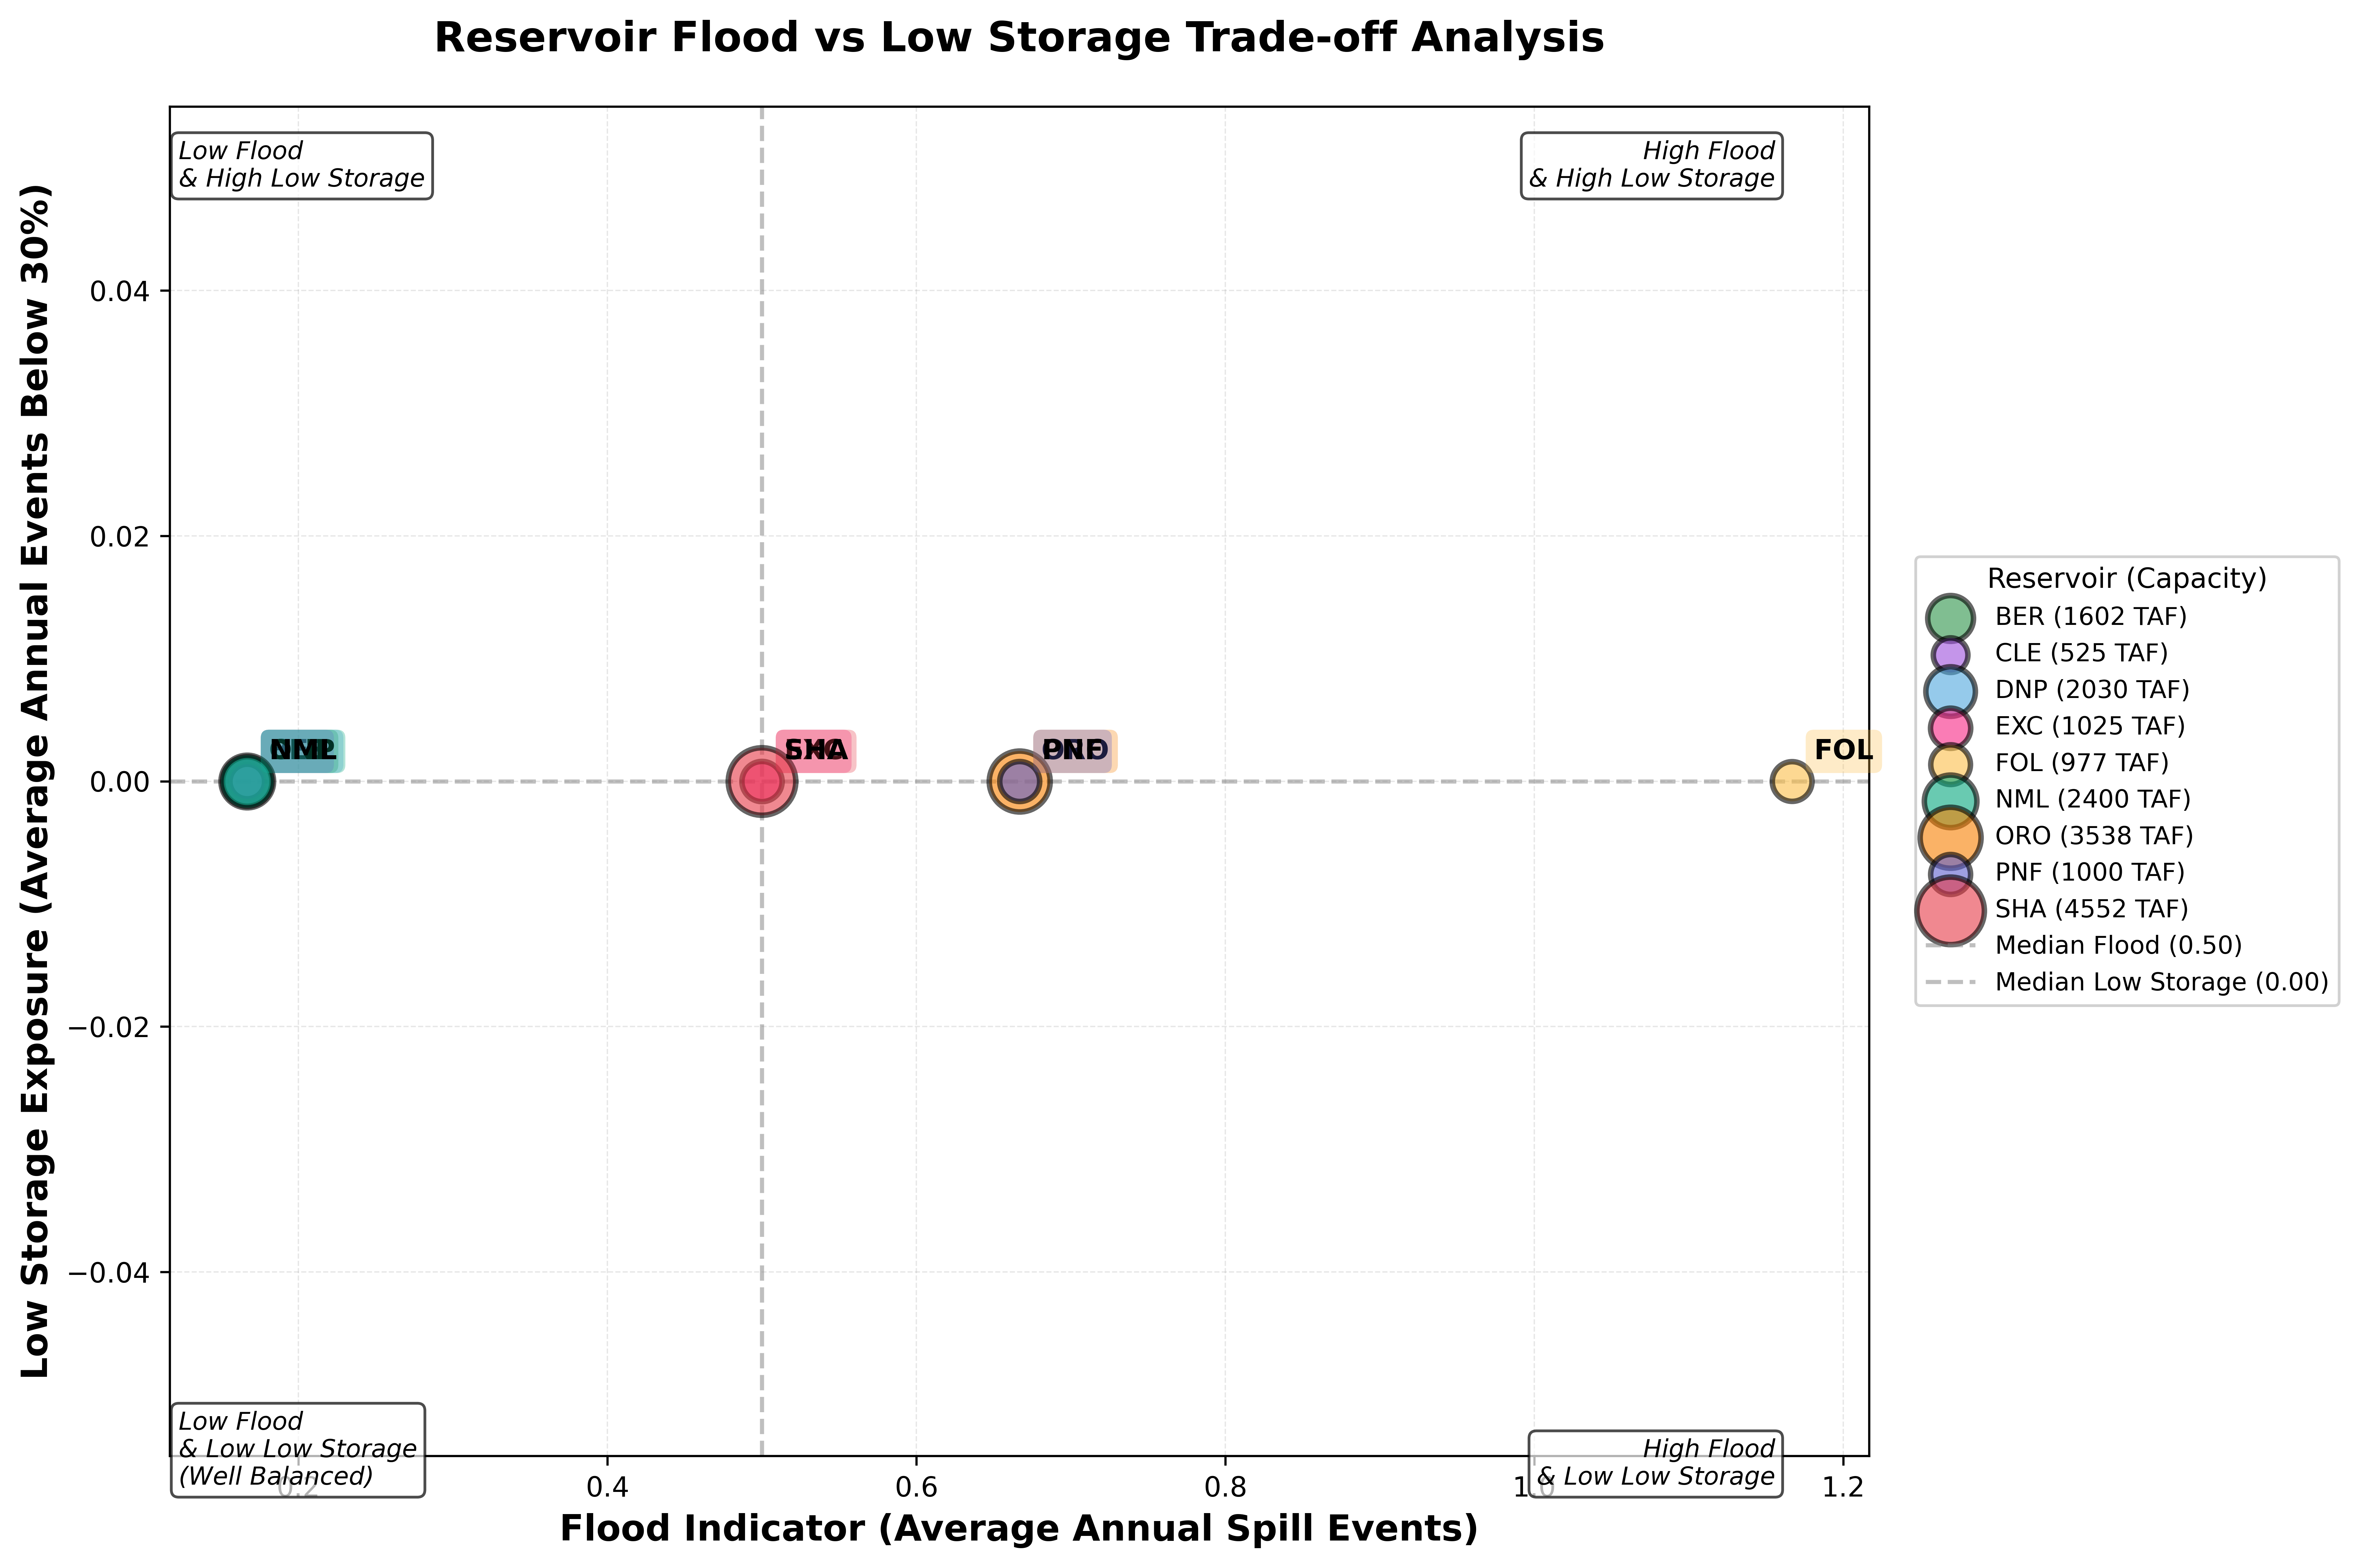

In [ ]:
# Create scatter plot (Task 6)
# Make sure you've run the mass balance analysis first!
if 'reservoir_indicators' not in locals():
    print("ERROR: Please run the mass balance analysis cell first!")
    print("Run the cell that calls: analyze_reservoir_mass_balance(...)")
else:
    fig, ax = plot_flood_vs_low_storage_scatter(
        reservoir_indicators,
        save_path='/Users/weilynnw/Documents/GitHub/CEE690-ESAA/A2_output/flood_vs_low_storage_scatter.png'
    )
    plt.show()


In [ ]:
# Statistical Analysis of Flood vs Low Storage Indicators

print("="*80)
print("STATISTICAL ANALYSIS: FLOOD VS LOW STORAGE")
print("="*80)

# Calculate correlation
correlation = reservoir_indicators['flood_indicator'].corr(
    reservoir_indicators['low_storage_exposure']
)

print(f"\n1. CORRELATION ANALYSIS:")
print(f"   Pearson correlation coefficient: {correlation:.3f}")

if abs(correlation) < 0.3:
    strength = "weak"
elif abs(correlation) < 0.7:
    strength = "moderate"
else:
    strength = "strong"

direction = "positive" if correlation > 0 else "negative"
print(f"   Interpretation: {strength.capitalize()} {direction} correlation")

if correlation > 0:
    print(f"   → Reservoirs with more spill events tend to have more low storage events")
else:
    print(f"   → Reservoirs with more spill events tend to have fewer low storage events")

# Summary statistics
print(f"\n2. SUMMARY STATISTICS:")
print(f"\n   Flood Indicator (spill events per year):")
print(f"     Mean: {reservoir_indicators['flood_indicator'].mean():.2f}")
print(f"     Median: {reservoir_indicators['flood_indicator'].median():.2f}")
print(f"     Std Dev: {reservoir_indicators['flood_indicator'].std():.2f}")
print(f"     Range: {reservoir_indicators['flood_indicator'].min():.2f} - {reservoir_indicators['flood_indicator'].max():.2f}")

print(f"\n   Low Storage Exposure (events per year):")
print(f"     Mean: {reservoir_indicators['low_storage_exposure'].mean():.2f}")
print(f"     Median: {reservoir_indicators['low_storage_exposure'].median():.2f}")
print(f"     Std Dev: {reservoir_indicators['low_storage_exposure'].std():.2f}")
print(f"     Range: {reservoir_indicators['low_storage_exposure'].min():.2f} - {reservoir_indicators['low_storage_exposure'].max():.2f}")

# Identify extreme reservoirs
print(f"\n3. EXTREME CASES:")

# Highest flood indicator
max_flood = reservoir_indicators.loc[reservoir_indicators['flood_indicator'].idxmax()]
print(f"\n   Highest Flood Indicator: {max_flood['Reservoir']}")
print(f"     - Spill events/year: {max_flood['flood_indicator']:.2f}")
print(f"     - Low storage events/year: {max_flood['low_storage_exposure']:.2f}")
print(f"     - Capacity: {max_flood['Max_Capacity_TAF']:.0f} TAF")

# Highest low storage exposure
max_low = reservoir_indicators.loc[reservoir_indicators['low_storage_exposure'].idxmax()]
print(f"\n   Highest Low Storage Exposure: {max_low['Reservoir']}")
print(f"     - Low storage events/year: {max_low['low_storage_exposure']:.2f}")
print(f"     - Spill events/year: {max_low['flood_indicator']:.2f}")
print(f"     - Capacity: {max_low['Max_Capacity_TAF']:.0f} TAF")

# Best balanced (lowest sum of normalized indicators)
reservoir_indicators['normalized_flood'] = (
    reservoir_indicators['flood_indicator'] / reservoir_indicators['flood_indicator'].max()
)
reservoir_indicators['normalized_low'] = (
    reservoir_indicators['low_storage_exposure'] / reservoir_indicators['low_storage_exposure'].max()
)
reservoir_indicators['balance_score'] = (
    reservoir_indicators['normalized_flood'] + reservoir_indicators['normalized_low']
)

best_balanced = reservoir_indicators.loc[reservoir_indicators['balance_score'].idxmin()]
print(f"\n   Most Balanced (lowest combined stress): {best_balanced['Reservoir']}")
print(f"     - Spill events/year: {best_balanced['flood_indicator']:.2f}")
print(f"     - Low storage events/year: {best_balanced['low_storage_exposure']:.2f}")
print(f"     - Capacity: {best_balanced['Max_Capacity_TAF']:.0f} TAF")

# Relationship with capacity
print(f"\n4. CAPACITY RELATIONSHIPS:")

corr_capacity_flood = reservoir_indicators['Max_Capacity_TAF'].corr(
    reservoir_indicators['flood_indicator']
)
corr_capacity_low = reservoir_indicators['Max_Capacity_TAF'].corr(
    reservoir_indicators['low_storage_exposure']
)

print(f"   Correlation (Capacity vs Flood Indicator): {corr_capacity_flood:.3f}")
print(f"   Correlation (Capacity vs Low Storage): {corr_capacity_low:.3f}")

print("\n" + "="*80)


STATISTICAL ANALYSIS: FLOOD VS LOW STORAGE

1. CORRELATION ANALYSIS:
   Pearson correlation coefficient: nan
   Interpretation: Strong negative correlation
   → Reservoirs with more spill events tend to have fewer low storage events

2. SUMMARY STATISTICS:

   Flood Indicator (spill events per year):
     Mean: 0.46
     Median: 0.50
     Std Dev: 0.34
     Range: 0.17 - 1.17

   Low Storage Exposure (events per year):
     Mean: 0.00
     Median: 0.00
     Std Dev: 0.00
     Range: 0.00 - 0.00

3. EXTREME CASES:

   Highest Flood Indicator: FOL
     - Spill events/year: 1.17
     - Low storage events/year: 0.00
     - Capacity: 977 TAF

   Highest Low Storage Exposure: BER
     - Low storage events/year: 0.00
     - Spill events/year: 0.17
     - Capacity: 1602 TAF


/Users/weilynnw/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/weilynnw/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ValueError: Encountered all NA values

## Interpretation of Results
### Key Observations:
#### 1. **Correlation Analysis**
The correlation coefficient indicates whether there is a relationship between flood events and low storage events:
#### 2. **Quadrant Analysis**
#### 3. **Capacity Relationships**
#### 4. **Outliers and Special Cases**
#### 5. **Operational Implications**
### Management Recommendations:


## Example: Plot Individual Reservoir
You can plot any individual reservoir from the results:


In [ ]:

if 'FOL' in mass_balance_results:
    plot_storage_timeseries(
        mass_balance_results['FOL'],
        reservoir_name='FOL',
        max_storage_tafd=RESERVOIR_CAPACITIES['FOL']
    )
    plt.show()